In [1]:
import pennylane as qml

In [2]:
H = qml.Hamiltonian(
[1, 1, 0.5],
[qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0)@qml.PauliX(1)]
)
print(H)

(1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


In [3]:
dev = qml.device('default.qubit', wires=2)

In [4]:
t = 1
n = 2


In [5]:
@qml.qnode(dev)
def circuit():
    qml.templates.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

circuit()
print(circuit.draw())

 0: ──H──────RZ(1)──H──H──╭RZ(0.5)──H──H──────RZ(1)──H──H──╭RZ(0.5)──H──┤ ⟨Z⟩ 
 1: ──RZ(1)──H────────────╰RZ(0.5)──H──RZ(1)──H────────────╰RZ(0.5)──H──┤ ⟨Z⟩ 



In [6]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])
    
@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

circuit(0.5)
print(circuit.draw())

 0: ──RX(0.5)──╭C──┤ ⟨Z⟩ 
 1: ──H────────╰X──┤ ⟨Z⟩ 



In [7]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

circuit([0.3, 0.4, 0.5])
print(circuit.draw())

 0: ──RX(0.3)──╭C──RX(0.4)──╭C──RX(0.5)──╭C──┤ ⟨Z⟩ 
 1: ──H────────╰X──H────────╰X──H────────╰X──┤ ⟨Z⟩ 



In [52]:
# QAOA Code
from pennylane import qaoa
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

In [53]:
# edges = open('data.txt', "r")
# print(edges.read())
# with open("data.txt", "r") as data_edges:
#     edges = data_edges.read()
    
# elems = ([f.strip(" {}'") for f in edges.strip().split(',')])

# edges_list = zip(elems[::2], elems[1::2])

# edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
# # graph_list = nx.Graph(edges_list)
# graph = nx.Graph(edges)
# print(edges)
# # print(edges_list)

# nx.draw(graph, with_labels=True)
# # nx.draw(graph_list, with_labels=True)
# plt.show()

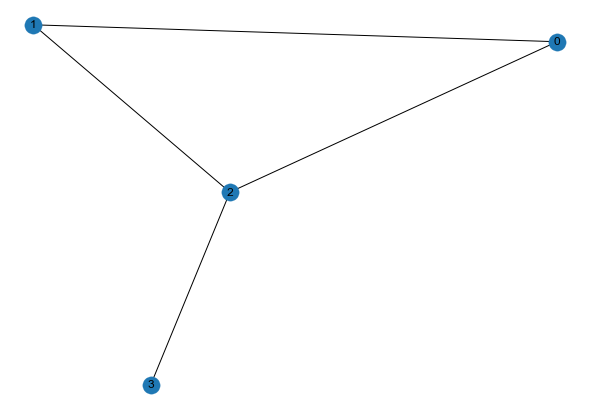

In [100]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
# # graph_list = nx.Graph(edges_list)
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [101]:
# with open("data1.txt", encoding='utf-8') as data_edges:
#     edges = data_edges.read()

# print(edges)
# elems = ([f.strip(" {}'") for f in edges.strip().split(',')])

# print(elems)
# edges_list = zip(elems[::2], elems[1::2])

# print(edges_list)
# graph_list = nx.Graph(edges_list)

# nx.draw(graph_list, with_labels=True)
# plt.show()

In [102]:
# cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)
print("Cost hamiltonian: ", cost_h)
print("Mixer Hamiltonian: ", mixer_h)

Cost hamiltonian:  (0.75) [Z0 Z1]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (0.75) [Z0 Z2]
+ (1.25) [Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
+ (-0.25) [Z3]
Mixer Hamiltonian:  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [103]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [104]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [105]:
dev = qml.device("qulacs.simulator", wires=wires)
cost_function = qml.ExpvalCost(circuit, cost_h, dev)

In [106]:
optimizer = qml.GradientDescentOptimizer()
steps = 20
params = [[0.5, 0.5], [0.5, 0.5]]

In [107]:
for i in range(steps):
    params = optimizer.step(cost_function, params)
    
print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.625280032240049, 0.9113192880743046], [0.5180154423607389, 0.8246915171322331]]


In [49]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

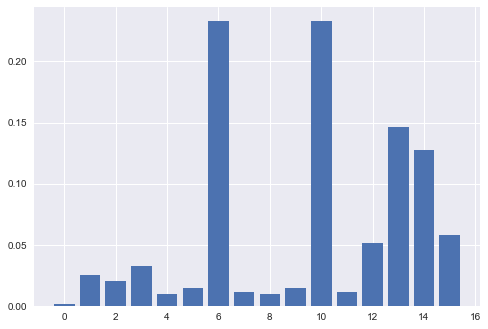

In [50]:
plt.style.use("seaborn")
plt.bar(range(2**len(wires)), probs)
plt.show()